In [1]:
import random
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader

from polara import get_movielens_data
from polara.preprocessing.dataframes import reindex

from neural_dice_v2 import ValueNetwork, NeuralDice
from policy import RandomPolicy, PopularRandomPolicy
from data import MovieLensBasicMDP, transform_indices

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
RANDOM_SEED = 12
DEVICE = torch.device('cuda:1')
BATCH_SIZE = 2
NUM_SAMPLES = 8192
NUM_ITER = 10000
EVAL_ITER = 1000

ZETA_POS = False # squared output of zeta(s,a)                  (used in GenDICE, BestDice)
ZETA_REWARD = False # whether include the reward in loss or not (used in MQL, BestDICE)
NORM_REGULARIZER = 0.0 # use lambda or not (not supported yet)  (used in GenDICE, GradientDICE, BestDICE)
PRIMAL_REGULARIZER = 0.0 # alpha_Q                              (used in GenDICE, GradientDICE)
DUAL_REGULARIZER = 1.0 # alpha_zeta                             (used in DualDICE, BestDICE)

NU_LR = 0.0001
ZETA_LR = 0.0001
GAMMA = 0.99

In [3]:
data = get_movielens_data(local_file='./data/ml-1m.zip', include_time=True)
data, _ = transform_indices(data, 'userid', 'movieid')

sequences = data.sort_values(['userid', 'timestamp']).groupby('userid', sort=False)['movieid'].apply(list)

sequences

userid
0       [2969, 1178, 1574, 957, 2147, 1658, 3177, 2599...
1       [1108, 1120, 1127, 2512, 1201, 2735, 1135, 110...
2       [579, 2651, 3301, 1788, 1327, 1781, 1174, 1279...
3       [1120, 1025, 3235, 466, 3294, 253, 1106, 1108,...
4       [2512, 847, 858, 1158, 346, 2651, 1050, 2007, ...
                              ...                        
6035    [1574, 2235, 3206, 1703, 2183, 2298, 2621, 262...
6036    [1702, 3275, 672, 1175, 1848, 2932, 802, 548, ...
6037    [859, 3165, 1120, 1965, 346, 1288, 1007, 1066,...
6038    [275, 107, 1886, 869, 1139, 2809, 886, 2872, 2...
6039    [802, 579, 2191, 1781, 1839, 559, 1316, 207, 2...
Name: movieid, Length: 6040, dtype: object

In [4]:
NUM_ITEMS = data['movieid'].max() + 1
ITEMS_COUNT = data.movieid.value_counts().sort_index().values.tolist()

In [5]:
def custom_collate(data_list):
    first_state = []
    current_state = []
    current_action = []
    next_state = []
    rewards = []
    step_num = []

    for fs, cs, ca, ns, rw, sn in data_list:
        first_state.append(fs)
        current_state.append(cs)
        current_action.append(ca)
        next_state.append(ns)
        rewards.append(rw)
        step_num.append(sn)

    return (
        torch.concat(first_state, dim=0),
        torch.concat(current_state, dim=0),
        torch.concat(current_action, dim=0),
        torch.concat(next_state, dim=0),
        torch.concat(rewards, dim=0),
        torch.concat(step_num, dim=0)
    )

loader_generator = torch.Generator()
loader_generator.manual_seed(RANDOM_SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed+worker_id)

dataset = MovieLensBasicMDP(
    num_items=NUM_ITEMS,
    user_sequences=sequences.values.tolist(),
    num_samples=NUM_SAMPLES
)

loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    prefetch_factor=4,
    pin_memory=True,
    collate_fn=custom_collate,
    persistent_workers=True,
    worker_init_fn=seed_worker,
    generator=loader_generator
)

In [6]:
policy = RandomPolicy(
    num_actions=NUM_ITEMS,
    device=DEVICE,
    name='random',
    seed=RANDOM_SEED
)

# policy = PopularRandomPolicy(
#     items_count=ITEMS_COUNT,
#     device=DEVICE,
#     name='pop_random',
#     seed=RANDOM_SEED
# )

In [7]:
nu = ValueNetwork(
    num_layers=2,
    state_dim=NUM_ITEMS,
    action_dim=NUM_ITEMS,
    hidden_dim=64,
    squared_output=False,
    seed=RANDOM_SEED
)
nu = nu.to(DEVICE)

zeta = ValueNetwork(
    num_layers=2,
    state_dim=NUM_ITEMS,
    action_dim=NUM_ITEMS,
    hidden_dim=64,
    squared_output=ZETA_POS,
    seed=RANDOM_SEED+1
)
zeta = zeta.to(DEVICE)

nu_optimizer = torch.optim.Adam(list(nu.parameters()), lr=NU_LR)
zeta_optimizer = torch.optim.Adam(list(zeta.parameters()), lr=ZETA_LR)

dice = NeuralDice(
    nu_network=nu,
    zeta_network=zeta,
    nu_lr=NU_LR,
    zeta_lr=ZETA_LR,
    lambda_lr=NU_LR,
    num_actions=NUM_ITEMS,
    gamma=GAMMA,
    zero_reward=ZETA_REWARD,
    f_exponent=1.5,
    primal_form=False,
    num_action_samples=None, # number of action samples used in Q expectation
    primal_regularizer=PRIMAL_REGULARIZER,
    dual_regularizer=DUAL_REGULARIZER,
    norm_regularizer=NORM_REGULARIZER,
    nu_regularizer=0.0, # nu network regularizer
    zeta_regularizer=0.0, # zeta network regularizer
    weight_by_gamma=False, # weight loss by gamma**step_num
    device=DEVICE
)

In [8]:
def estimate_policy(data: MovieLensBasicMDP):
    values = []
    for batch in data.iterate_dataset(batch_size=100):
        batch = [b.to(DEVICE) for b in batch]
        states, actions, rewards = batch

        values.append(
            dice.estimate_average_reward(
                states=states,
                actions=actions,
                rewards=rewards
            )
        )

    return sum(values)

In [ ]:
nu_losses = []
zeta_losses = []
values = []

i = 0
for batch in loader:
    if i >= NUM_ITER:
        break

    batch = [b.to(DEVICE) for b in batch]

    nu_loss, zeta_loss = dice.train_batch(batch=batch, policy=policy)
    nu_losses.append(nu_loss)
    zeta_losses.append(zeta_loss)

    if i % EVAL_ITER  == 0 or i == (NUM_ITER - 1):
        value = estimate_policy(data=dataset)
        print(f'Value on iteration {i}: {value}')
        values.append(value)

    i += 1

# Value on iteration 9999: 400.99662471562624 (random)
# Value on iteration 9999: 593.9174272567034 (poprandom)

Value on iteration 0: -34652.282279610634
Value on iteration 1000: -0.20180410984903574
Value on iteration 2000: -1.8682003282010555
Value on iteration 3000: 19.375169291975908
Value on iteration 4000: -26.766984709596727


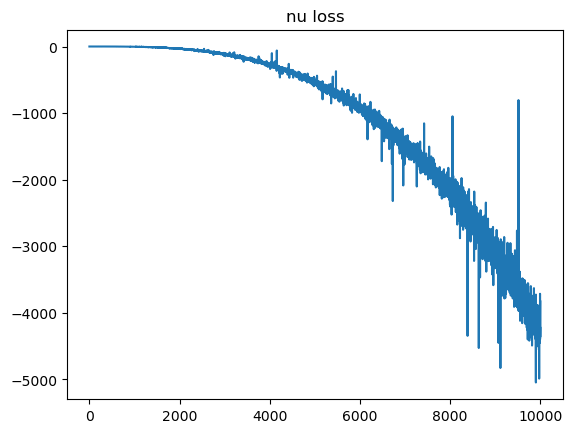

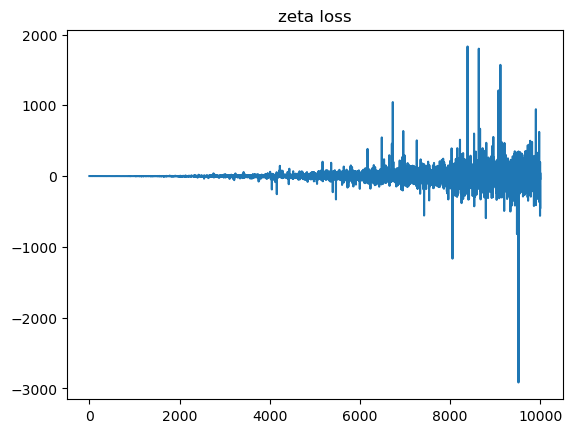

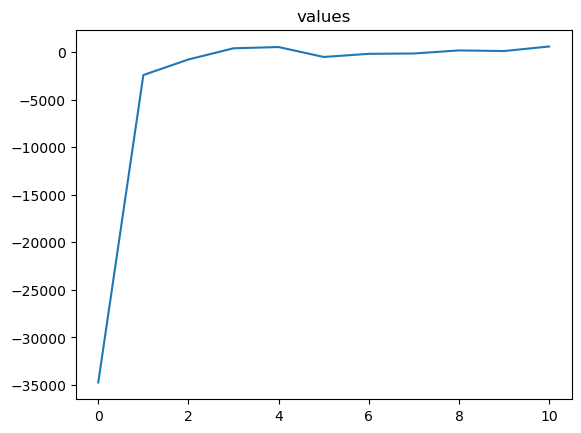

In [ ]:
plt.plot(nu_losses)
plt.title('nu loss')
plt.show()

plt.plot(zeta_losses)
plt.title('zeta loss')
plt.show()

plt.plot(values)
plt.title('values')
plt.show()